In [110]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

#from mpltools import special ##leon

class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1
        self.keytime=keytime # 2
        self.ttime=ttime # 3
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx
        self.hmd_ry=hmd_ry
        self.hmd_rz=hmd_rz

def read_data(file,rawdata):
    print("Reading %s"%file)
    seperator="\t"
    with open(file,"r") as fp:
        for line in fp:
            if line.startswith("Time"):
                continue
            l=line[:-1]
            f=l.split(seperator) 
            if(int(f[3])==1):
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
            else: 
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
                
    return rawdata

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime
        
class posDataClass(object):
    def __init__(self,targetid,target_lon,target_lat,zeroTime,relativeTime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.zeroTime=zeroTime
        self.relativeTime = relativeTime

def process_time(raw_data):
    timeData={}
    filteredData=[a for a in raw_data if a.keypress==1]
    for i in range(len(filteredData)-1):
        if(filteredData[i+1].targetid!=filteredData[i].targetid):
            continue # when resuming back
        if((i <= len(filteredData)-3) and (filteredData[i-1].targetid==filteredData[i+2].targetid)):
            continue # when two same targets appear one after one
        deltaTime=filteredData[i+1].ttime-filteredData[i].ttime
        #print(deltaTime, filteredData[i].targetid)

        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        if(key1 in timeData)==False:
            timeData[key1]={}
        if(key2 in timeData[key1])==False:
            timeData[key1][key2]=[]
        
        timeData[key1][key2].append(TimeData(filteredData[i].targetid,filteredData[i].target_lon,filteredData[i].target_lat,deltaTime))
    timeData[str(0)][str(0)]=[]   
    timeData[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))
#    print(timeData['0'][str(180)])
        #print(key1, key2)
    return timeData

def track_head(raw_data):
    posData = {}
    zeroTime = 0
    currentTargetID = 0

    for i in range(len(raw_data)):
        if (raw_data[i].keypress == 1 and raw_data[i].targetid != currentTargetID):
            zeroTime = raw_data[i].ttime
            currentTargetID = raw_data[i].targetid
        continue
        relativeTime = raw_data[i].ttime - zeroTime
        
        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        key3=str(zeroTime)
        if(key1 in timeData)==False:
            posData[key1]={}
        if(key2 in timeData[key1])==False:
            posData[key1][key2]={}
        if(key3 in timeData[key1][key2])==False:
            posData[key1][key2][key3]=[]
        
        posData[key1][key2].append(posDataClass(raw_data[i].targetid,raw_data[i].target_lon,raw_data[i].target_lat, zeroTime, relativeTime))
        
    return posData

def plotTrial(raw_data,fig,raw,col,idx):
    #fig = plt.figure()
    ax = fig.add_subplot(raw,col,idx)
    for i in range(13):
        tx=[a.tx for a in raw_data if a.keypress==1]
        ty=[a.ty for a in raw_data if a.fittstrial==trial and a.tid==i]
        x=[a.x for a in raw_data if a.fittstrial==trial and a.tid==i]
        y=[a.y for a in raw_data if a.fittstrial==trial and a.tid==i]
        z=[a.z for a in raw_data if a.fittstrial==trial and a.tid==i]


        mpl.rcParams['legend.fontsize'] = 7

        ax.scatter(tx,ty)
        ax.plot(x, y, label='tid:'+str(i))
    #ax.legend()


def read_plot(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    #key1=['-30','0','30']
    key1=['0','0','0']
    key2=[30,60,90,120,150,180]
    #return timeData


    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            #if(k1==1 and k2==0):
            #if(k2==0):
            #    m1.append(0)
            #    s1.append(0)
            #    continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
        means.append(m1)
        stddev.append(s1)        
    return means

def read_plot2(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    
    
    if (len(timeData) == 3):
        m1=[]
        s1=[]
        data=[]

        for k2 in range(len(key2)):

            data.extend([a.deltatime for a in timeData[key1[0]][str(key2[k2])]])
            data.extend([a.deltatime for a in timeData[key1[1]][str(key2[k2])]])
            data.extend([a.deltatime for a in timeData[key1[2]][str(key2[k2])]])

            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
        
    #print (means) 
    means.append(m1)
    stddev.append(s1)
    #print (means) 

    return means


def read_plot3(path,raw,fig): # return
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    

    key1=['-30','0','30']
    if (len(timeData) == 1):
        key1=['0']
    #key1=['0']
    key2=[0,30,60,90,120,150,180]
    #return timeData

    
    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
            #if(k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            #angle = math.degrees(math.acos(math.cos(math.radians(0)) * math.cos(math.radians(30*k2)))) #k1
            angle = 30*k2 # for condition 3,4,5 only
            speed=[]
            print(str(data))
            
            for i in range(len(data)):
                print(str(angle),str(data[i]))
                if (data[i] == 0):
                    speed.append(0)
                    continue
                speed.append(angle / data[i])
                
            #np.true_divide(angle, data)
            mean=np.mean(speed)
            std=np.std(speed)
            
            m1.append(mean)
            s1.append(std)
            
        means.append(m1)
        stddev.append(s1)
    
    #print (means) 
    means.append(m1)
    stddev.append(s1)
    #print (means) 

    return means,stddev


def make_ratio(mean_before, mean_after):
    
    ratio=[]
    
    for i in range(len(mean_before)):
        r=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                r.append(1) #ratio
                #r.append(0) #log
                continue
            r.append(mean_before[i][j]/mean_after[i][j]) #ratio
            #r.append(math.log2(mean_before[i][j]/mean_after[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        
    return ratio

def make_speed(time):
    
    key1=[-30, 0, 30]
    key2=[0,30,60,90,120,150,180]
    
    speed=[]
    
    for i in range(len(time)-1):
        r=[]
        for j in range(len(time[i])):
            
            if(time[i][j]==0):
                #r.append(0) # speed = 0
                r.append(0)
                continue
            #r.append( (math.sqrt(key1[i] * key1[i] + key2[j] * key2[j])) / mean[i][j] )
            
            r.append( math.degrees(math.acos(math.cos(math.radians(key1[i])) * math.cos(math.radians(key2[j])))) / time[i][j] )
            #print(
        speed.append(r)
    #print("speed0" + str(speed))
    
    if (len(time) == 3):
        r=[]
        for j in range(len(time[1])):
            if(time[1][j]==0):
                #r.append(0) # speed = 0
                r.append( (speed[0][j] + speed[2][j]) / 2 )
                continue
            r.append( (speed[0][j] + speed[1][j] + speed[2][j]) / 3 ) 
        speed.append(r)
    
    #print("speed1" + str(speed))
        
    return speed

def plotbar(r,s=None):
    
    plt.figure(1, figsize = (9,16))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    ax = plt.gca()
    
    plt.bar(x-offset,r[0], width, label="-30", color="C0")
    plt.bar(x,r[1], width, label="0", color="C1")
    plt.bar(x+offset,r[2], width, label="30", color="C2")

    ax.set_xlabel('Group')
    ax.set_ylabel('Scores')
    
    ax.legend()
    plt.xticks(x,key2)
    plt.show()
    
def plotcontrast(r1,r2,r3,s1,s2,s3):

    plt.figure(1, figsize = (12,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    x = np.arange(7)
    width = 0.2
    offset = 0.4
    opacity = 0.2
    ax = plt.gca()
    
    
    plt.bar(x-offset*0.5,r1, width, label="condition 3", color="C0", alpha=1-opacity, yerr=s1)
    plt.bar(x,r2, width, label="condition 4", color="C0", alpha=1-2*opacity, yerr=s2)
    plt.bar(x+offset*0.5,r3, width, label="condition 5", color="C0", alpha=1-3*opacity, yerr=s3)

    ax.set_xlabel('Target')
    ax.set_ylabel('Speed')
    
    ax.legend(loc = 2)
    plt.ylim(0,100) # speed
    plt.xticks(x,key2)
    plt.show()
    
    

def plotratio(r,s=None):
    plt.figure(1, figsize = (8,8))
    key1=['-30','0','30']
    #key2=[0,30,60,90,120,150,180]
    key2=[0,30,60,90,120,150,180]
    key3=[30,60,90,120,150,180]
    
    #print(r[0])    
    #print(r[2])
    
    if(s!=None):
        print(r[1],s[1],key2)
        #ar1 = np.array(r[1])
        #as1 = np.array(s[1])
        #print(ar1,as1)
        ymax=[[],[],[]]
        ymin=[[],[],[]]
        xmean=[[],[],[]]
        for j in range(3):
            #ymax[j] = []
            for i in range(6):
                ymax[j].append(r[j][i] + s[j][i])
                ymin[j].append(r[j][i] - s[j][i])
                xmean[j].append((r[0][i] + r[1][i] + r[2][i]) / 3)
            xmean[j][0] = (r[0][0] + r[2][0]) / 2                    
        #color='crimson', color="limegreen" color='C0'
        
###################### plot 3 latitude, with error/standard deviation  (old, bar)
        #plt.errorbar(key2, r[2], label="30", yerr=s[2], fmt='-x',color='crimson',markersize=10,elinewidth=0.5,capsize=10,capthick=0.5)
        #plt.errorbar(key2, r[1], label="0", yerr=s[1], linewidth=2, fmt = '-x',markersize=10, elinewidth=1,capsize=5,capthick=0.5)
        #plt.errorbar(key2, r[0], label="-30", yerr=s[0], fmt=':v',markersize=10,elinewidth=2,capsize=10,capthick=0.5)

        #ax.errorbar(key2, r[0], label="-30-2",yerr=s[0], linestyle='dotted')       
        #ax.fill_between(key2, np.array(r[1]-s[1]),np.array(r[1]+s[1]), facecolor='blue', alpha=0.5)
        #plt.fill_betweenx(key2,r[1]-s[1], r[1]+s[1])
        
###################### plot 3 latitude, with error/standard deviation (new, area/shade)   
        #plt.fill_between(np.array(key2), ymin[0], ymax[0],alpha=0.2, label="-30")
        #plt.fill_between(np.array(key2), ymin[1], ymax[1],alpha=0.2, label="0")
        #plt.fill_between(np.array(key2), ymin[2], ymax[2],alpha=0.2, label="30")
        plt.plot(key2, r[0], ':v', label="-30")
        plt.plot(key2, r[1], '-o', label="0")
        plt.plot(key2, r[2], ':^', label="30")
        
###################### plot single latitude
        #pltid = 0;
        ##plt.fill_between(np.array(key2), ymin[pltid], ymax[pltid],alpha=0.2, label=key1[pltid],color='C'+ str(pltid))
        ##plt.plot(key2, r[pltid], '-x', markersize=10, label=key1[pltid],color='C'+ str(pltid), linewidth =2)
        #plt.plot(key2, xmean[1], '-x', markersize=10, label='all', color='black', linewidth =2) #combine all latitude
######################
    else:
        plt.plot(key2, r[0], ':v', label="-30") 
        plt.plot(key2, r[1], '-o', label="0")
        plt.plot(key2, r[2], ':^', label="30")
    
#    special.errorfill(key2, means1[0], y_err=stddev1[0], label='sin', label_fill='sin error')
#    special.errorfill(x, y_cos, y_err, label='cos', label_fill='cos error',alpha_fill=0.1)
#    plt.fill_between(key2, means1[2]-stddev1[2], means1[2]+stddev1[2])
###################### set figure scale
    #plt.axhline(y=0,linewidth=1, color='r') #log
    #plt.axhline(y=1,linewidth=1, color='r') #ratio
    plt.xticks(key2)
    #plt.ylim(-1,1) #log
    plt.ylim(0,100) # speed
    plt.xlim(-10)    
    #plt.rcParams["axes.grid.axis"] ="y"
    #plt.rcParams["axes.grid"] = True
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.legend(title="latitude", loc = 4)
    plt.ylabel('ratio')
    #plt.ylabel('log')
    plt.xlabel('target longtitude')

    plt.savefig('user'+str(users[uid])+'.pdf')
    plt.show()
    


Reading ../Users/14/3.txt
Reading ../Users/14/4.txt
Reading ../Users/14/5.txt
[[0.0, 1.191360000000003, 1.6169599999999946, 1.5753000000000044, 1.8521999999999934, 2.2218250000000026, 2.6987749999999977], [0.0, 1.191360000000003, 1.6169599999999946, 1.5753000000000044, 1.8521999999999934, 2.2218250000000026, 2.6987749999999977]]
Reading ../Users/14/3.txt
[0.0]
0 0.0
[1.2895000000000039, 1.3295000000000243, 1.0646000000000129, 1.0948999999999955, 1.1782999999999788]
30 1.2895000000000039
30 1.3295000000000243
30 1.0646000000000129
30 1.0948999999999955
30 1.1782999999999788
[1.6968999999999994, 1.7302000000000248, 1.2905999999999835, 1.4907999999999788, 1.8762999999999863]
60 1.6968999999999994
60 1.7302000000000248
60 1.2905999999999835
60 1.4907999999999788
60 1.8762999999999863
[1.825000000000017, 1.5486999999999966, 1.5044999999999789, 1.4883000000000095, 1.5100000000000193]
90 1.825000000000017
90 1.5486999999999966
90 1.5044999999999789
90 1.4883000000000095
90 1.5100000000000193


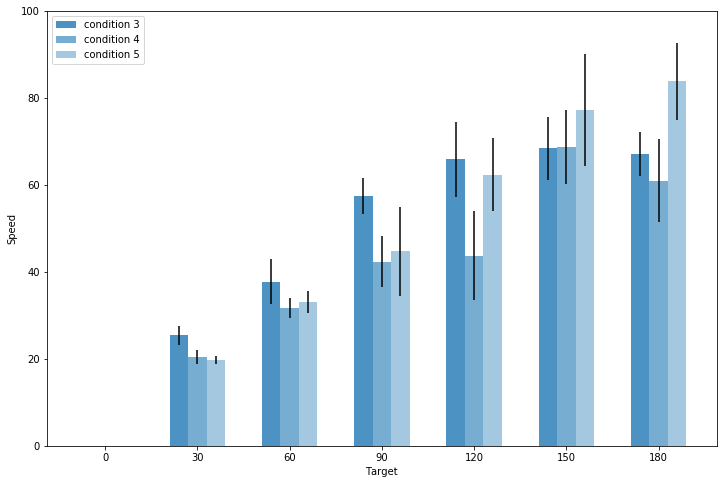

Reading ../Users/16/3.txt
Reading ../Users/16/4.txt
Reading ../Users/16/5.txt
[[0.0, 1.562519999999995, 1.9017750000000149, 2.1496399999999882, 2.278120000000013, 2.8136600000000103, 4.107740000000012], [0.0, 1.562519999999995, 1.9017750000000149, 2.1496399999999882, 2.278120000000013, 2.8136600000000103, 4.107740000000012]]
Reading ../Users/16/3.txt
[0.0]
0 0.0
[1.48660000000001, 1.606299999999976, 1.623199999999997, 1.6995000000000005, 1.3969999999999914]
30 1.48660000000001
30 1.606299999999976
30 1.623199999999997
30 1.6995000000000005
30 1.3969999999999914
[2.1229000000000156, 1.8759000000000015, 1.8541999999999916, 1.7541000000000508]
60 2.1229000000000156
60 1.8759000000000015
60 1.8541999999999916
60 1.7541000000000508
[2.0206000000000017, 2.3770999999999844, 1.691699999999969, 2.237099999999998, 2.421699999999987]
90 2.0206000000000017
90 2.3770999999999844
90 1.691699999999969
90 2.237099999999998
90 2.421699999999987
[2.5780000000000314, 2.4168000000000234, 2.169300000000021

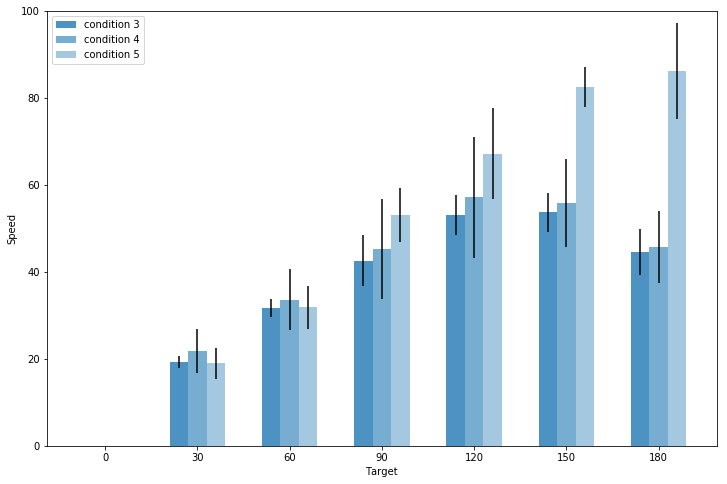

Reading ../Users/17/3.txt
Reading ../Users/17/4.txt
Reading ../Users/17/5.txt
[[0.0, 1.1599199999999996, 1.4910166666666573, 1.5956200000000138, 1.9827399999999897, 2.3185600000000024, 2.4694250000000295], [0.0, 1.1599199999999996, 1.4910166666666573, 1.5956200000000138, 1.9827399999999897, 2.3185600000000024, 2.4694250000000295]]
Reading ../Users/17/3.txt
[0.0]
0 0.0
[1.7615999999999872, 1.0207000000000335, 1.1352999999999724, 0.9750000000000227, 0.9069999999999823]
30 1.7615999999999872
30 1.0207000000000335
30 1.1352999999999724
30 0.9750000000000227
30 0.9069999999999823
[1.9610000000000127, 1.0430999999999813, 1.7980999999999767, 1.066099999999949, 1.6335000000000264, 1.4442999999999984]
60 1.9610000000000127
60 1.0430999999999813
60 1.7980999999999767
60 1.066099999999949
60 1.6335000000000264
60 1.4442999999999984
[1.7177000000000078, 1.737799999999993, 1.5793000000000461, 1.3233999999999924, 1.6199000000000296]
90 1.7177000000000078
90 1.737799999999993
90 1.5793000000000461
90

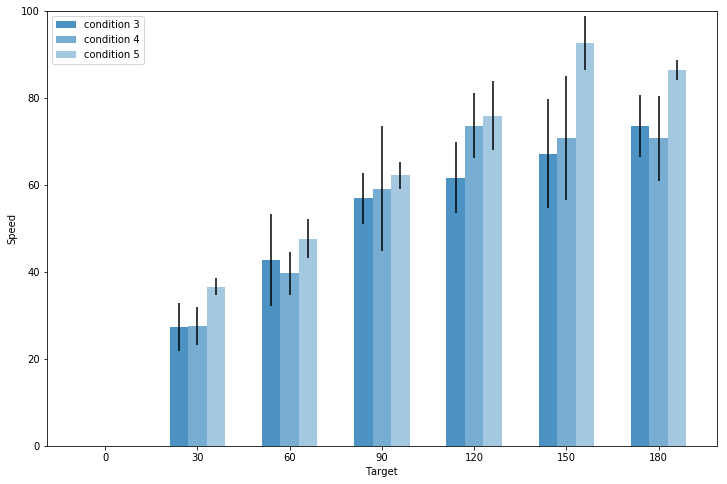

Reading ../Users/18/3.txt
Reading ../Users/18/4.txt
Reading ../Users/18/5.txt
[[0.0, 1.1671166666666484, 1.7216333333333107, 1.413919999999996, 2.044100000000005, 2.2564833333333447, 2.287983333333339], [0.0, 1.1671166666666484, 1.7216333333333107, 1.413919999999996, 2.044100000000005, 2.2564833333333447, 2.287983333333339]]
Reading ../Users/18/3.txt
[0.0]
0 0.0
[1.633299999999963, 1.121499999999969, 1.029800000000023, 1.0045999999999822, 1.257599999999968, 0.9558999999999855]
30 1.633299999999963
30 1.121499999999969
30 1.029800000000023
30 1.0045999999999822
30 1.257599999999968
30 0.9558999999999855
[3.7314999999999827, 1.3129000000000133, 1.6123999999999796, 1.2750999999999522, 1.1282999999999674, 1.2695999999999685]
60 3.7314999999999827
60 1.3129000000000133
60 1.6123999999999796
60 1.2750999999999522
60 1.1282999999999674
60 1.2695999999999685
[1.3560999999999694, 1.66640000000001, 1.6435000000000173, 1.1791000000000054, 1.2244999999999777]
90 1.3560999999999694
90 1.66640000000

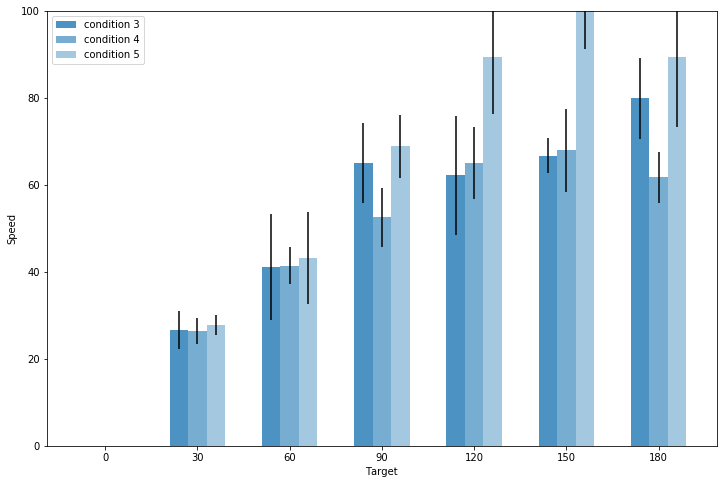

Reading ../Users/19/3.txt
Reading ../Users/19/4.txt
Reading ../Users/19/5.txt
[[0.0, 1.255099999999993, 1.4057249999999897, 1.7062199999999847, 1.8463399999999637, 2.81707499999996, 3.473940000000016], [0.0, 1.255099999999993, 1.4057249999999897, 1.7062199999999847, 1.8463399999999637, 2.81707499999996, 3.473940000000016]]
Reading ../Users/19/3.txt
[0.0]
0 0.0
[0.9975000000000591, 1.4575999999999567, 1.3092000000000326, 1.1318999999999733, 1.3792999999999438]
30 0.9975000000000591
30 1.4575999999999567
30 1.3092000000000326
30 1.1318999999999733
30 1.3792999999999438
[1.222599999999943, 1.6640999999999622, 1.2874000000000478, 1.4488000000000056]
60 1.222599999999943
60 1.6640999999999622
60 1.2874000000000478
60 1.4488000000000056
[2.1236999999999853, 1.4857000000000653, 1.7328999999999724, 1.9028999999999314, 1.2858999999999696]
90 2.1236999999999853
90 1.4857000000000653
90 1.7328999999999724
90 1.9028999999999314
90 1.2858999999999696
[1.9993999999999232, 1.8700999999999794, 1.72429

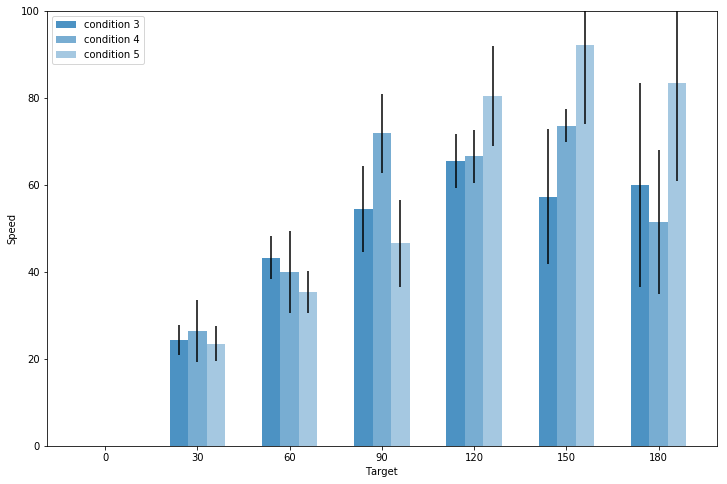

Reading ../Users/15/3.txt
Reading ../Users/15/4.txt
Reading ../Users/15/5.txt
[[0.0, 1.0078999999999922, 1.3445000000000011, 1.6246749999999963, 2.0248000000000133, 2.3416399999999955, 4.038749999999993], [0.0, 1.0078999999999922, 1.3445000000000011, 1.6246749999999963, 2.0248000000000133, 2.3416399999999955, 4.038749999999993]]
Reading ../Users/15/3.txt
[0.0]
0 0.0
[0.9676999999999794, 1.1555000000000177, 0.8147999999999911, 1.0935999999999808]
30 0.9676999999999794
30 1.1555000000000177
30 0.8147999999999911
30 1.0935999999999808
[1.075999999999965, 1.0436000000000263, 1.9139000000000124]
60 1.075999999999965
60 1.0436000000000263
60 1.9139000000000124
[1.8811000000000035, 1.5073999999999614, 1.606300000000033, 1.5038999999999874]
90 1.8811000000000035
90 1.5073999999999614
90 1.606300000000033
90 1.5038999999999874
[1.998800000000017, 2.2472999999999956, 1.8532000000000153, 1.999900000000025]
120 1.998800000000017
120 2.2472999999999956
120 1.8532000000000153
120 1.999900000000025
[

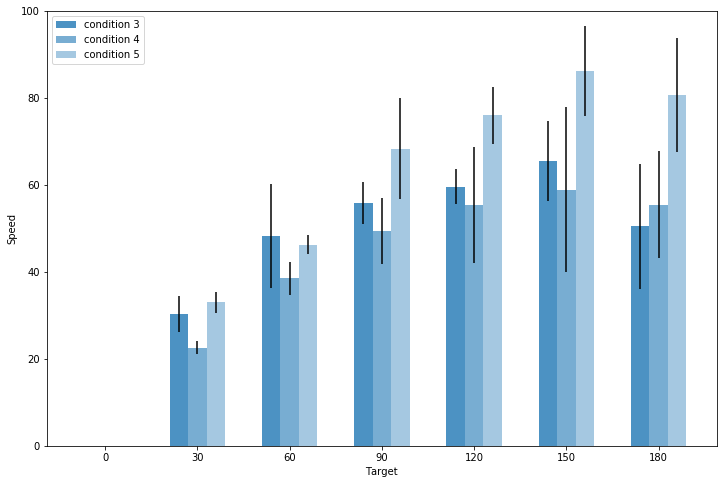

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
speed1=[]
speed2=[]
speed3=[]
ratio=[[],[],[]]
###################### choose user
#users=[1,2,3,4,5,9,10,14,6,13]#,8,12,11]#,7]
users=[14,16,17,18,19,15]
######################
for uid in range(len(users)):
    baseFolder=str(users[uid])

    idx=[3,4,5]
    #idx=[1,2,3]

   # for i in range(len(idx)):
    #print("Trial 1"+str(i))
    t1=read_plot2("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    #print("Trial 2"+str(i))
    t2=read_plot2("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    t3=read_plot2("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    
    s1 = make_speed(t1)
    print(t1)
    s2 = make_speed(t2)
    s3 = make_speed(t3)
    #r1=make_ratio(t1,t2)
    #r2=make_ratio(t1,t3)
    #r3=make_ratio(t2,t3)
    
    ts1, tsdev1 = read_plot3("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    ts2, tsdev2 = read_plot3("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    ts3, tsdev3 = read_plot3("../Users/"+baseFolder+"/"+str(idx[2])+".txt",1,fig)
    
    speed1.append(s1)
    speed2.append(s2)
    speed3.append(s3)
    
    print(np.array(t1).shape)
    print(np.array(s1).shape)
    #ratio[2].append(r3[0])
    
    ratio[0].append(s1[0])
    ratio[1].append(s2[0])
    ratio[2].append(s3[0])
    
    #plotbar(r1)
    #plotratio(r1)
    #plotcontrast(s1[0],s2[0],s3[0]) # angle cal is not correct
    
    plotcontrast(ts1[0],ts2[0],ts3[0],tsdev1[0],tsdev2[0],tsdev3[0])

    #plotcontrast(s1[3],s2[3]) #all 3
    #plotratio(r3)
    
  

RRR
[0, 0, 0, 0, 0, 0]
RRR
[34.75827802618079, 26.50181892665117, 35.700412191591546, 35.48027655841732, 32.993085896957275, 41.085050212591696]
RRR
[39.791394794394996, 33.8321272110235, 43.152498000298536, 37.3721235997283, 45.77075439843866, 47.855034382108336]
RRR
[57.1319748619309, 41.86747548426736, 56.40440706433814, 63.65282335634283, 52.748180187783994, 55.39569452352021]
RRR
[62.444069902416416, 50.76945300214854, 58.33286576820757, 56.58182391920893, 62.642257803685965, 57.121150865890215]
RRR
[62.37681990738648, 49.25626333342644, 59.774333159689206, 61.4187465262592, 49.19655241366705, 59.18517700873294]
RRR
[55.580772758010625, 36.5164299590528, 60.74288548953631, 65.55991812294654, 43.17863866388001, 37.14020427112355]
(1, 7)
[[0.0, 34.41982030206497, 41.29565539766539, 54.53342591303058, 57.98193687692628, 56.867982058193554, 49.78647487742497]] [[0.0, 4.321161944317846, 4.828060046989199, 6.554557530928426, 4.009853818187397, 5.502455748608525, 11.417122266273948]]
RRR

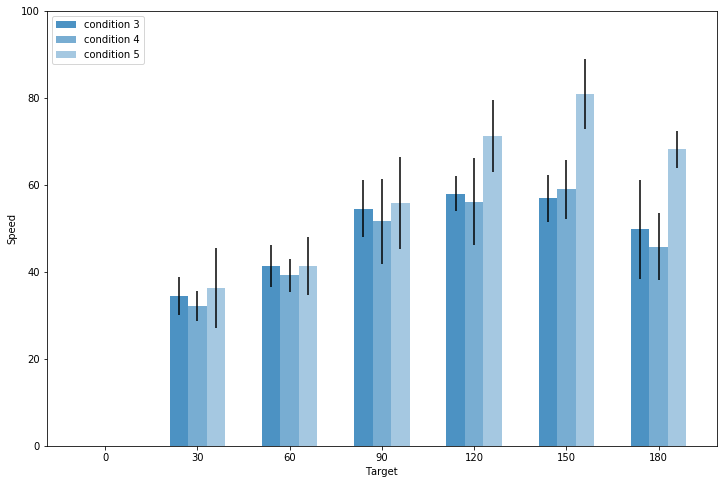

TypeError: plotcontrast() missing 3 required positional arguments: 's1', 's2', and 's3'

In [120]:
def calMean(data):

    meanR=[]
    stdR=[]
    
    #print(len(data[0]))
    
    for i in range(1): # 3 when all 3
        meanR.append([])
        stdR.append([])
        
        for j in range(7):
            r=[]
            
            if (i==1 and j==0):
                continue
            for k in range(len(data)):
                #print("i=" + str(i) + ",j=" + str(j) + ",k=" + str(k)) 
                r.append(data[k][i][j])
                #print("ok!")
            
            print("RRR")
            print(str(r))
            
            meanR[i].append(np.mean(r))
            stdR[i].append(np.std(r))
            
    print(np.array(meanR).shape)
    
    return meanR, stdR

speedMean1, speedStd1 = calMean(speed1)
print(str(speedMean1),str(speedStd1))
speedMean2, speedStd2 = calMean(speed2)
speedMean3, speedStd3 = calMean(speed3)


def ratio_average(ratio):
    ratioDiv=[[],[],[]]
    meanR=[[],[],[]]
    stdR=[[],[],[]]
    #print(np.array(ratio).shape)
    for i in range(7):
        for j in range(3):
            userAverage=[]
            for k in range(len(ratio[j])):
                userAverage.append(ratio[j][k][i])
            ratioDiv[j].append(np.mean(userAverage))
            meanR[j].append(np.mean(ratioDiv[j][i]))
            stdR[j].append(np.std(ratioDiv[j]))
    return meanR
print(np.array(ratio).shape)
ratioMean = ratio_average(ratio)
print(np.array(ratioMean).shape)
print("rationMean")
print(str(ratioMean))
    
#print(np.array(speedMean1).shape)
#print(np.array(speed1).shape)
#print(meanR,StdR)
#plotratio(meanR,StdR)
plotcontrast(speedMean1[0],speedMean2[0],speedMean3[0], speedStd1[0], speedStd2[0], speedStd3[0])
plotcontrast(ratioMean[0],ratioMean[1],ratioMean[2])

